# <span style="font-size:larger;font-weight:bold">Data Processing</span>

## Vizualizing the available data

In [703]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Color palette
custom_palette = sns.color_palette(['#3366cc', '#dc3912', '#ff9900', '#109618', '#990099', "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b'])

class TravelPlotter:
    '''
    A class for plotting trail data
    
    Method:
    plot_travel_count: a funtion that plots the number of trails for each mode of transport.
    plot: a function that plots the number of trails available for a given mode of transport based on regions of New York State
    plot_trail_type: a function that vizualizes the number of types of trail in New York States.
    '''
    def __init__(self, data):
        self.data = data
        self.color_dict = {"On Foot": custom_palette[0], "On Horse": custom_palette[1], "On Bike": custom_palette[2], "On Snowmobile": custom_palette[3], "Accessible": custom_palette[4]}
        self.color_dict_Unit = {'Allegany': custom_palette[0], 'Central': custom_palette[1], 'Finger Lakes': custom_palette[2], 'Genesee': custom_palette[3], 'Long Island': custom_palette[4],
       'New York City': custom_palette[5], 'Niagara': custom_palette[6], 'Palisades': custom_palette[7], 'Saratoga': custom_palette[8], 'Taconic': custom_palette[9],
       'Thousand Islands': custom_palette[10]}
    def plot_travel_count(self):
        plo = self.data[["Foot", "Horse", "Bike", "Snowmb", "Accessible"]]
        plo = plo.copy()
        plo.loc[:,['Foot', 'Horse', 'Bike', 'Snowmb', 'Accessible']] = plo.loc[:,['Foot', 'Horse', 'Bike', 'Snowmb', 'Accessible']].replace({'Y': 1, 'N': 0}).astype(int)
        
        plo = plo.sum()
        plo = plo.reset_index()
        plo.columns = ["Mode of transport", "Available Trails"]
        plo["Mode of transport"] = plo["Mode of transport"].replace(["Foot", "Horse", "Bike", "Snowmb", "Accessible"], ["On Foot", "On Horse", "On Bike", "On Snowmobile", "Accessible"])
        plo = plo.sort_values(by="Available Trails", ascending=False)
        sns.set_style("whitegrid")
        fig, ax = plt.subplots(figsize=(10, 6))
        ax = sns.barplot(x="Available Trails", y="Mode of transport", data=plo, palette=self.color_dict)
        ax.set_xlabel("Number of Trails")
        ax.set_ylabel("Mode of transport")
        ax.set_title("Number of Trails by Mode of Transport in NYS")
        plt.show()
    
    def plot(self, transport_mode):
        df = self.data[['Unit', transport_mode]]
        df = df[df[transport_mode] == 'Y']
        df = df.groupby('Unit')[transport_mode].count().reset_index(name='Available Trails')
        df = df.sort_values(by='Available Trails', ascending=False)
        sns.barplot(data=df, x='Available Trails', y='Unit', orient='h', palette=self.color_dict_Unit)
        plt.xlabel('Available Trails')
        plt.ylabel('Unit')
        plt.title(f'Total available trails for {transport_mode}')
        plt.show()
    def plot_trail_type(self):
        #The type of trail paths
        plt.xticks(rotation=90)
        sns.histplot(data=self.data, x='Asset', color="Purple", label="Sepal Length", kde=True)
        plt.show()
        
data = pd.read_csv('Finalized_Trail_paths.csv')
tp = TravelPlotter(data)

In [696]:
data.Unit.unique()

array(['Allegany', 'Central', 'Finger Lakes', 'Genesee', 'Long Island',
       'New York City', 'Niagara', 'Palisades', 'Saratoga', 'Taconic',
       'Thousand Islands'], dtype=object)

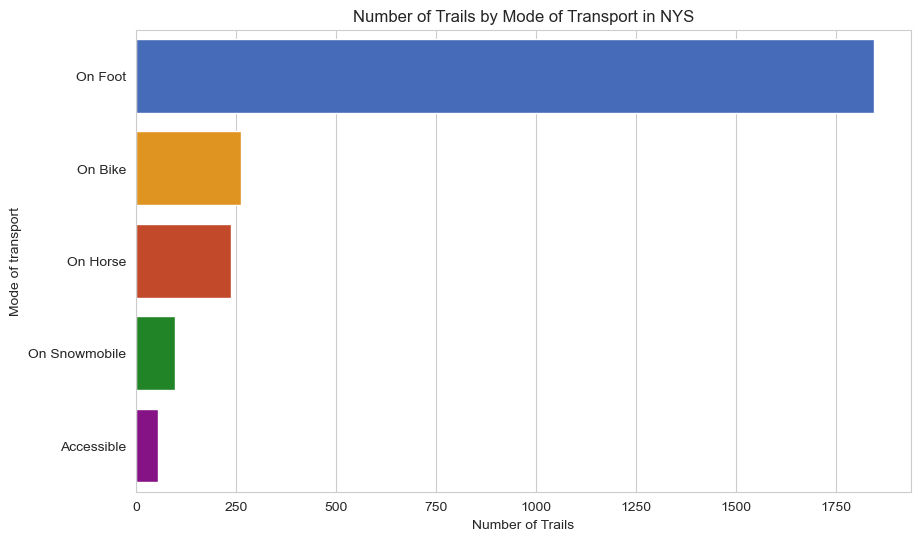

In [704]:
tp.plot_travel_count()

NYS is divided into regions. The following plots show the distribution of trail paths in these regions

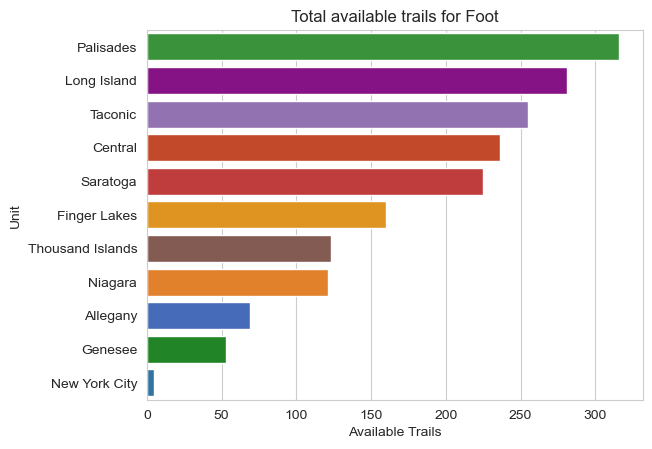

In [700]:
tp.plot('Foot')

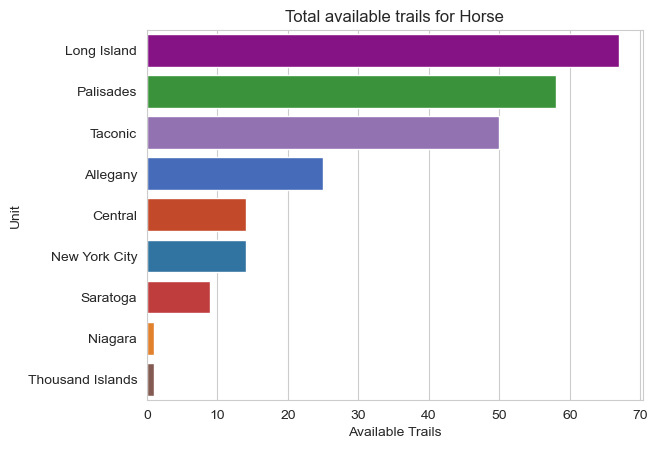

In [670]:
tp.plot('Horse')

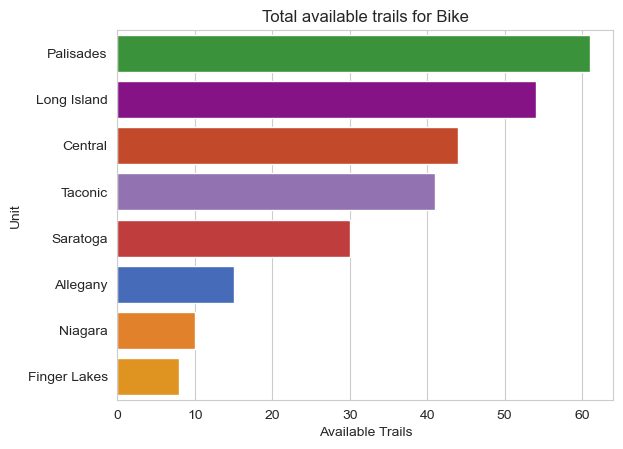

In [671]:
tp.plot('Bike')

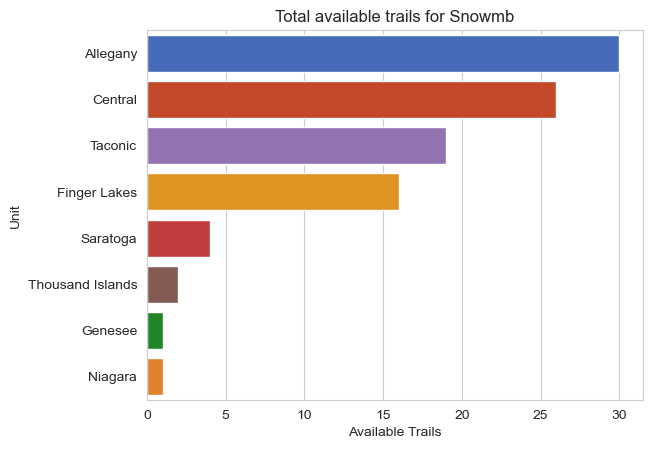

In [672]:
tp.plot('Snowmb')

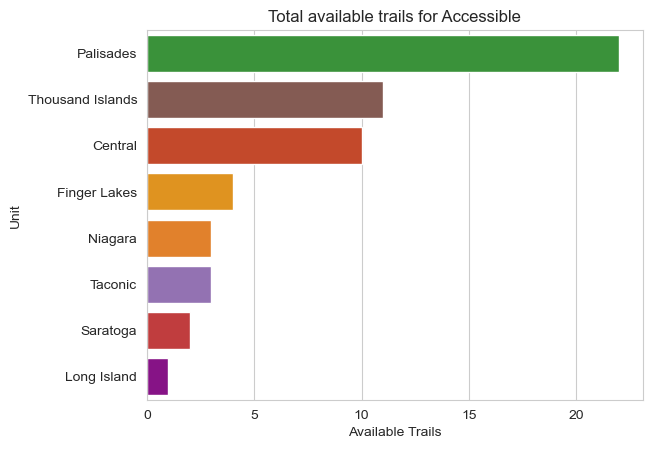

In [673]:
tp.plot('Accessible')

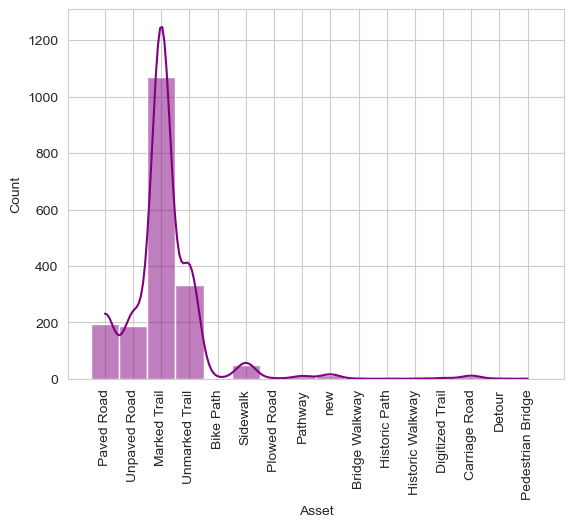

In [674]:
#The type of trail paths
tp.plot_trail_type()

From the above histogram it is clear that most trail paths are either marked or unmarked trail followed by some paved and unpaved roads. Unmarked trails can be difficult to navigate especially for a beginner. The type_factor a factor in trail difficulty deems marked trail as easy compared to unmarked trails. Therefore we will take anything but the unmarked and marked trails as 0 and marked trail as 0.1 and unmarked trail as 0.3 value when calculating the trail difficulty score. 

## Model for trail difficulty prediction
I have calculated difficulty rating for the trails by a weighted sum of trail length and elevation. Another factor added to it is the trail type, which is explained above. 
Here I will be developing a model that will be able to predict the difficulty rating for any new trail given its above mentioned features.

In [688]:
from sklearn.base import TransformerMixin, RegressorMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

class TrailDifficultyRegressor(TransformerMixin, RegressorMixin, BaseEstimator):
    """
    A machine learning model to predict the difficulty level of a hiking trail based on various features.
    
    Method:
    fit: function to fit the regression model using the training data.
    transform: function to predict the target variable using the test data.
    score: function to score the performance of the model by comparing actual and predicted values.
    
    """
    def __init__(self, features, target):
        """
        Constructor for the TrailDifficultyRegressor class.

        Parameters:
            features (list of str): The names of the features used in the model.
            target (str): The name of the target variable.
            
        """
        self.features = features
        self.target = target

        # Define preprocessing steps for numerical and categorical features
        numerical_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        self.preprocessor = ColumnTransformer(transformers=[
            ('num', numerical_transformer, ['Shape_Leng', 'Elevation_Gain', 'Angle_of_Descent']),
            ('cat', categorical_transformer, ['type_factor'])
        ])

        # Define the regression model with preprocessor as first step
        self.regressor = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            #('regressor', LinearRegression())
            ('regressor', RandomForestRegressor(n_estimators=1000))
        ])

    def fit(self, X_train, y_train):
        self.regressor.fit(X_train[self.features], y_train[self.target])
        return self
    
    def transform(self, X_test):
        return self.regressor.predict(X_test[self.features])
    
    def score(self, X_test, y_test):
        fig, ax = plt.subplots(figsize = (4, 4), dpi =200)
        ax.scatter(y_test[self.target], y_pred, c='blue', label='Predicted')
        ax.scatter(y_test[self.target], y_test[self.target], c='red', label='Actual')
        ax.set_xlabel("Actual values")
        ax.set_ylabel("Predicted values")
        ax.set_title("Actual vs Predicted values")
        ax.legend()
        plt.show()
        return mean_squared_error(y_test[self.target], y_pred)

In [676]:
# Define the features and target variable
features = ['Shape_Leng', 'Elevation_Gain', 'Angle_of_Descent', 'type_factor']
target = 'DR'

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, data, test_size=0.2, random_state=42)

# Create instance of TrailDifficultyRegressor class
regressor = TrailDifficultyRegressor(features=features, target=target)

In [677]:
# Fit the model using cross-validation
scores = cross_val_score(regressor.regressor, X_train[features], y_train[target], cv=5, scoring='r2')

# Print the cross-validation scores
print('Cross-validation scores:', scores)

Cross-validation scores: [0.99396115 0.99264689 0.98947624 0.99109782 0.99083185]


The cross-validation scores are all above **98 %**. This suggest that the model is performing well and has good generalization.

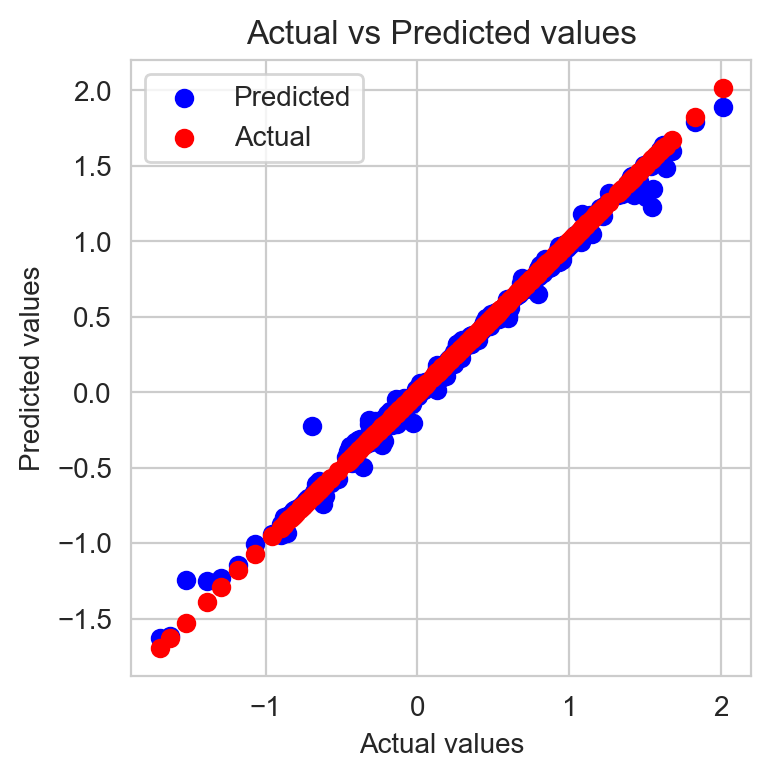

R^2 score: 0.0028418476944249756


In [678]:
# Fit the model on the training data
regressor.fit(X_train, y_train)

# Predict difficulty for test data
y_pred = regressor.transform(X_test)

# Evaluate the model performance on the test set
score = regressor.score(X_test, y_test)
print('R^2 score:', score)

## Trail recommendation model
The trail recommendation takes user's preferred mode of travel into account along with length of trail and elevation gain . I want to recommend trails to user based on their needs. For this I develop a model that will recommend trails based on cosine similarity with the user input.

In [690]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from geopy.geocoders import Nominatim
from geopy import distance
from geopy.distance import geodesic
import requests


class TrailRecommendation:
    """
    A class to recommend trails to users based on their preferences and location.

    Attributes:
        trails (list): a list of trail objects containing information about each trail
        
    Method:
    preprocess_data: a function to encode the trail data
    get_lat_long: a helper function that finds the latitude and longitude based on zip code
    get_recommendation: main function that generates recommedations to the user based on their input and returns top 20 matching trails.
    """
    def __init__(self, df):
        """
        Initializes a TrailRecommendation object with a list of trail objects.
        
        """
        self.df = df
        self.categorical_features = ['Foot', 'Horse', 'Bike', 'Snowmb', 'Accessible']
        self.numerical_features = ['Shape_Leng', 'Elevation_Gain']
        self.type_factor_mapping = {'easy': 0, 'medium': 0.1, 'hard': 0.3}
        
    def preprocess_data(self):
        # One-hot encode categorical features
        for feature in self.categorical_features:
            self.df[feature] = self.df[feature].map({'Y': 1, 'N': 0})
        self.df['type_factor'] = self.df['type_factor'].map({0.0: 'easy', 0.1: 'medium', 0.3: 'hard'})
        # Define the bins for the classes
        elevation_bins = [self.df['Elevation_Gain'].min(), 30, 120, self.df['Elevation_Gain'].max()]
        length_bins = [self.df['Shape_Leng'].min(), 1600, 4828, self.df['Shape_Leng'].max()]
        self.df['Shape_Leng'] = pd.cut(self.df['Shape_Leng'], length_bins, labels=['low', 'medium', 'high'], include_lowest=True)
        self.df['Elevation_Gain'] = pd.cut(self.df['Elevation_Gain'], elevation_bins, labels=['low', 'medium', 'high'], include_lowest=True)
        enc = OneHotEncoder()
        encoded_data = enc.fit_transform(self.df[['Shape_Leng', 'Elevation_Gain', 'type_factor']])
        encoded_features = enc.get_feature_names_out(['Shape_Leng', 'Elevation_Gain', 'type_factor'])
        self.encoded_features = encoded_features
        encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoded_features)
        self.df = pd.concat([self.df, encoded_df], axis=1)
        return self.df
   
    def get_lat_long(self, zipcode):
        url = "https://nominatim.openstreetmap.org/search.php"
        params = {"q": zipcode, "format": "jsonv2", "countrycodes": "US"}

        try:
            response = requests.get(url, params=params)
            response_json = response.json()
            if len(response_json) > 0:
                latitude = response_json[0]['lat']
                longitude = response_json[0]['lon']
                return latitude, longitude
            else:
                return None, None
        except:
            return None, None

        
    def get_recommendations(self, user_input):
        # Preprocess user input
        user_df = pd.DataFrame(user_input, index=[0])
        for feature in self.categorical_features:
            user_df[feature] = user_df[feature].map({'Y': 1, 'N': 0})
        # Calculate distance between user's zipcode and each trail
        user_lat, user_long = self.get_lat_long(user_input['Zip'])
        
        user_df['Shape_Leng'] = pd.cut(user_df['Trail_Leng'], bins=[-np.inf, 1, 3, np.inf], labels=['low', 'medium', 'high'])
        user_df['Elevation_Gain'] = pd.cut(user_df['Elevation_Gain'], bins=[-np.inf, 30, 120, np.inf], labels=['low', 'medium', 'high'])
        user_df = pd.get_dummies(user_df, columns=['Shape_Leng', 'Elevation_Gain', 'type_factor'])
        # Add missing type_factor columns
        if 'type_factor_easy' not in user_df:
            user_df['type_factor_easy'] = 0
        if 'type_factor_medium' not in user_df:
            user_df['type_factor_medium'] = 0
        if 'type_factor_hard' not in user_df:
            user_df['type_factor_hard'] = 0
        dist=user_df['radius'].iloc[0]
        
        # Preprocess trail data
        #self.preprocess_data()
        # Filter trails by zip code
        self.df['distance'] = self.df.apply(lambda row: geodesic((user_lat, user_long), (row['latitude'], row['longitude'])).miles, axis=1)
        
        # Calculate cosine similarity between user input and trails
        X = self.df[self.categorical_features + list(self.encoded_features)]
        y = self.df['Name']
        user_X = user_df[X.columns]
        cosine_sim = cosine_similarity(X, user_X)
        sim_scores = list(enumerate(cosine_sim))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
        trail_indices = [i[0] for i in sim_scores]
        h=self.df.loc[trail_indices]
        # filter the DataFrame by the 'B' column and show the top 20 rows
        filtered_df = h[h['distance'] <= dist].head(20)
        #return y.iloc[trail_indices]
        return filtered_df

In [680]:
recommend = TrailRecommendation(data)

In [681]:
recommend.preprocess_data()

,Unit,site_name,latitude,longitude,address,phone,website,description,amenities,Name,...,DR,Shape_Leng_high,Shape_Leng_low,Shape_Leng_medium,Elevation_Gain_high,Elevation_Gain_low,Elevation_Gain_medium,type_factor_easy,type_factor_hard,type_factor_medium
0,Allegany,Allegany State Park - Quaker Area,42.038990,-78.843833,"2373 ASP, Rte 1Salamanca, NY 14779",(716) 354-2182,https://parks.ny.gov/parks/1,The Quaker area is known for its two lakes and...,"Boat Launches, Camper Assistance Program, Camp...",ASP 1,...,0.777134,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allegany,Allegany State Park - Quaker Area,42.038990,-78.843833,"2373 ASP, Rte 1Salamanca, NY 14779",(716) 354-2182,https://parks.ny.gov/parks/1,The Quaker area is known for its two lakes and...,"Boat Launches, Camper Assistance Program, Camp...",ASP1,...,1.451551,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,Allegany,Allegany State Park - Quaker Area,42.038990,-78.843833,"2373 ASP, Rte 1Salamanca, NY 14779",(716) 354-2182,https://parks.ny.gov/parks/1,The Quaker area is known for its two lakes and...,"Boat Launches, Camper Assistance Program, Camp...",Bay State Rd,...,0.507771,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,Allegany,Allegany State Park - Quaker Area,42.038990,-78.843833,"2373 ASP, Rte 1Salamanca, NY 14779",(716) 354-2182,https://parks.ny.gov/parks/1,The Quaker area is known for its two lakes and...,"Boat Launches, Camper Assistance Program, Camp...",Bay State Rd,...,0.319747,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,Allegany,Allegany State Park - Quaker Area,42.038990,-78.843833,"2373 ASP, Rte 1Salamanca, NY 14779",(716) 354-2182,https://parks.ny.gov/parks/1,The Quaker area is known for its two lakes and...,"Boat Launches, Camper Assistance Program, Camp...",Bay State Rd,...,1.297291,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,Thousand Islands,Whetstone Gulf State Park,43.702629,-75.459938,"6065 West Rd.Lowville, NY 13367",(315) 376-6630,https://parks.ny.gov/parks/92,Know Before You Go...More InfoPet PolicyA maxi...,"Fishing, Grills, Hiking, Hunting, Pavilions an...",North Rim Gorge Tail,...,1.019653,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1878,Thousand Islands,Whetstone Gulf State Park,43.702629,-75.459938,"6065 West Rd.Lowville, NY 13367",(315) 376-6630,https://parks.ny.gov/parks/92,Know Before You Go...More InfoPet PolicyA maxi...,"Fishing, Grills, Hiking, Hunting, Pavilions an...",North Rim Gorge Tail,...,0.775353,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1879,Thousand Islands,Whetstone Gulf State Park,43.702629,-75.459938,"6065 West Rd.Lowville, NY 13367",(315) 376-6630,https://parks.ny.gov/parks/92,Know Before You Go...More InfoPet PolicyA maxi...,"Fishing, Grills, Hiking, Hunting, Pavilions an...",Observation Tower Trail,...,0.320660,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1880,Thousand Islands,Whetstone Gulf State Park,43.702629,-75.459938,"6065 West Rd.Lowville, NY 13367",(315) 376-6630,https://parks.ny.gov/parks/92,Know Before You Go...More InfoPet PolicyA maxi...,"Fishing, Grills, Hiking, Hunting, Pavilions an...",South Rim Gorge Trail,...,1.237958,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [682]:
# Define user input
user_input = {
    'Zip' : '13074',
    'Foot': 'N',
    'Horse': 'N',
    'Bike': 'Y',
    'Snowmb': 'N',
    'Accessible': 'N',
    'Trail_Leng': 2,
    'Elevation_Gain': 80,
    'type_factor': 'easy',
    'radius': 50
}

# Get recommendations
recommendations = recommend.get_recommendations(user_input)

In [692]:
trails = pd.read_csv('Finalized_Trail_paths.csv')
res=trails.loc[recommendations.index]
res.rename(columns={'Shape_Leng':'Trail_Length(in miles)'}, inplace = True)
res.rename(columns={'Elevation_Gain':'Elevation_Gain(in meters)'}, inplace = True)
res['Trail_Length(in miles)'] = res['Trail_Length(in miles)'].apply(lambda x: x / 1609.34)
res

,Unit,site_name,latitude,longitude,address,phone,website,description,amenities,Name,...,type_factor,Foot,Horse,Bike,Snowmb,Accessible,Trail_Length(in miles),Elevation_Gain(in meters),Angle_of_Descent,DR
435,Finger Lakes,Sampson State Park,42.729141,-76.891724,"6096 Route 96ARomulus, NY 14541",(315) 585-6392,https://parks.ny.gov/parks/154,Know Before You Go...More InfoPet PolicyA maxi...,"Boat Launches, Camper Assistance Program, Camp...",Unnamed,...,0.0,Y,N,Y,N,N,2.733143,37.985214,0.494785,0.893843
433,Finger Lakes,Sampson State Park,42.729141,-76.891724,"6096 Route 96ARomulus, NY 14541",(315) 585-6392,https://parks.ny.gov/parks/154,Know Before You Go...More InfoPet PolicyA maxi...,"Boat Launches, Camper Assistance Program, Camp...",Unnamed,...,0.0,Y,N,N,N,N,2.955556,41.647034,0.501659,0.930216
1866,Thousand Islands,Westcott Beach State Park,43.898666,-76.122375,"Route 3Henderson, NY 13650",(315) 646-2239,https://parks.ny.gov/parks/90,Know Before You Go...More InfoPet PolicyA maxi...,"Campsites, Cabins & Lodging, Dockage, Fishing,...",Missing Trail Name,...,0.0,Y,N,N,N,N,2.477641,71.020287,1.020406,0.976975
1871,Thousand Islands,Westcott Beach State Park,43.898666,-76.122375,"Route 3Henderson, NY 13650",(315) 646-2239,https://parks.ny.gov/parks/90,Know Before You Go...More InfoPet PolicyA maxi...,"Campsites, Cabins & Lodging, Dockage, Fishing,...",Plateau Road,...,0.0,Y,N,N,N,N,1.752737,60.469299,1.228079,0.858843
220,Central,Green Lakes State Park,43.039238,-75.966187,"7900 Green Lakes RoadFayetteville, NY 13066",(315) 637-6111,https://parks.ny.gov/parks/172,Know Before You Go...More InfoBoatingDue to th...,"Boat Rentals, Campsites, Cabins & Lodging, Dis...",Deer Run Trail,...,0.1,Y,N,Y,N,N,2.121267,81.666641,1.370381,1.060774
235,Central,Green Lakes State Park,43.039238,-75.966187,"7900 Green Lakes RoadFayetteville, NY 13066",(315) 637-6111,https://parks.ny.gov/parks/172,Know Before You Go...More InfoBoatingDue to th...,"Boat Rentals, Campsites, Cabins & Lodging, Dis...",Rolling Hills Trail,...,0.1,Y,N,Y,N,N,1.581581,83.306152,1.874586,0.987725
241,Central,Green Lakes State Park,43.039238,-75.966187,"7900 Green Lakes RoadFayetteville, NY 13066",(315) 637-6111,https://parks.ny.gov/parks/172,Know Before You Go...More InfoBoatingDue to th...,"Boat Rentals, Campsites, Cabins & Lodging, Dis...",Vista Trail,...,0.1,Y,N,Y,N,N,1.361113,34.241867,0.895576,0.794159
305,Central,Verona Beach State Park,43.176266,-75.728050,"6541 Lakeshore Road SouthRoute 13Verona Beach,...",(315) 762-4463,https://parks.ny.gov/parks/102,Know Before You Go...More InfoPet PolicyA maxi...,"Camper Assistance Program, Campsites, Cabins &...",Road,...,0.0,Y,Y,Y,Y,N,1.345458,1.371696,0.036296,0.132224
221,Central,Green Lakes State Park,43.039238,-75.966187,"7900 Green Lakes RoadFayetteville, NY 13066",(315) 637-6111,https://parks.ny.gov/parks/172,Know Before You Go...More InfoBoatingDue to th...,"Boat Rentals, Campsites, Cabins & Lodging, Dis...",Emergency Road,...,0.0,Y,N,N,N,N,0.260117,40.941467,5.585861,0.293966
228,Central,Green Lakes State Park,43.039238,-75.966187,"7900 Green Lakes RoadFayetteville, NY 13066",(315) 637-6111,https://parks.ny.gov/parks/172,Know Before You Go...More InfoBoatingDue to th...,"Boat Rentals, Campsites, Cabins & Lodging, Dis...",Old Growth Trail,...,0.1,Y,N,N,N,N,1.429905,80.291595,1.998305,0.955052
